# xNES tests

Tests for the xNES implementation in PINTS.

We start by visually inspecting its behaviour on selected problems.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import *

import pints
import pints.toy
import pints.cptests.xnes as cp

from utils import (
    function,
    function_between_points,
    technicolor_dreamline,
    run_replicates,
)

method = pints.XNES
parallel = True

## Logistic model - no transformations


In [2]:
model = pints.toy.LogisticModel()

xtrue = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(xtrue, times)
values += np.random.normal(0, 5, values.shape)
problem = pints.SingleOutputProblem(model, times, values)

error = pints.SumOfSquaresError(problem)
xlim = [0, 0.5]
ylim = [10, 100]
boundaries = pints.RectangularBoundaries(
    [xlim[0], ylim[0]], [xlim[1], ylim[1]])

x0 = boundaries.sample(1)[0]

In [3]:
controller = pints.OptimisationController(
    error, x0, boundaries=boundaries, method=method)
controller.set_parallel(False)  # This is faster

b = pints.Timer()
xbest, fbest = controller.run()
print(b.format())

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Current   Time    
0     4      24654.91  24654.91   0:00.0
1     10     21866.52  21866.52   0:00.1
2     16     21582.48  21582.48   0:00.1
3     22     18979.16  18979.16   0:00.1
20    124    2907.984  2907.984   0:00.7
40    244    2211.489  2215.343   0:01.3
60    364    2211.426  2211.426   0:01.9
80    484    2211.425  2211.425   0:02.4
100   604    2211.425  2211.425   0:03.0
120   724    2211.425  2211.425   0:03.6
140   844    2211.425  2211.425   0:04.2
160   964    2211.425  2211.425   0:04.7
180   1084   2211.425  2211.425   0:05.4
200   1204   2211.425  2211.425   0:06.1
220   1324   2211.425  2211.425   0:06.6
240   1444   2211.425  2211.425   0:07.2
260   1564   2211.425  2211.425   0:07.8
280   1684   2211.425  2211.425   0:08.3
300   1804   2211.425  2211.425   0:08.8
309   1852   2211.425  2211.425   0:09.0
Halting: No sig

  Found       xbest        Relative error
   1.019e-01   1.000e-01   1.853% 
   4.979e+01   5.000e+01  -0.427% 



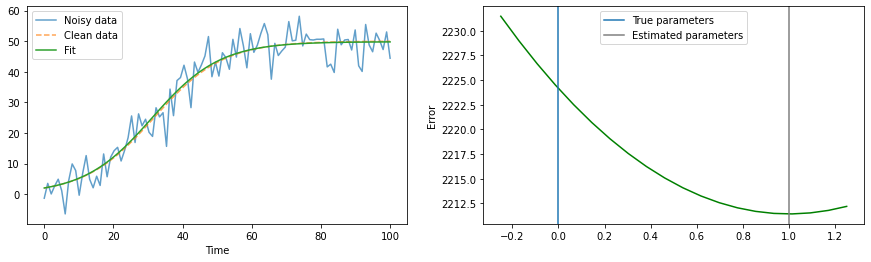

In [4]:
print('  Found       xbest        Relative error' )
for x, y in zip(xbest, xtrue):
    e = (x - y) / y    
    print(f'  {x:> 3.3e}  {y:> 3.3e}  {e:> 3.3%} ')
print()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time')
ax.set_label('Value')
ax.plot(times, values, label='Noisy data', alpha=0.7)
ax.plot(times, problem.evaluate(xtrue), '--', label='Clean data', alpha=0.7)
ax.plot(times, problem.evaluate(xbest), label='Fit')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
function_between_points(ax, error, xtrue, xbest)

plt.show()

Works well!

### Detailed run

In [5]:
x0 = [0.4, 90]
opt = method(x0, boundaries=boundaries)
walk = [x0]
for i in range(80):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

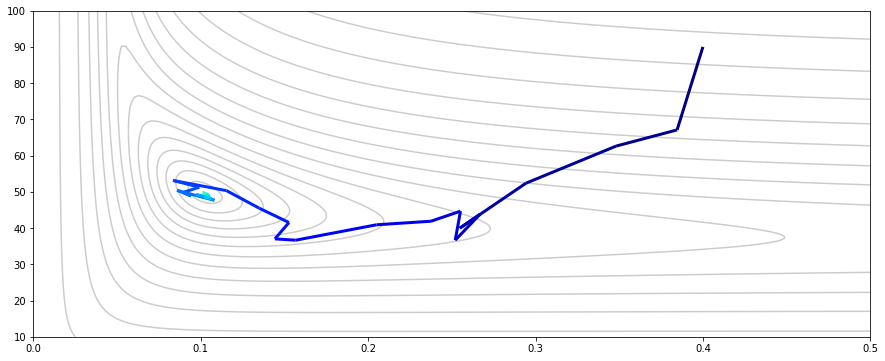

In [6]:
# Create points for contour plot of marginal density
levels = np.geomspace(1e3, 4e5, 20)
x = np.linspace(*xlim, 200)
y = np.linspace(*ylim, 150)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Interestingly, xNES starts off quite differently than CMAES does, but quickly converges to the same solution.

## Neal's funnel

In [7]:
log_pdf = pints.toy.NealsFunnelLogPDF()
x0 = 9 * np.ones(10, dtype=float)
x0[-1] = 7

opt = method(x0)
walk = [x0]
for i in range(200):
    opt.tell([-log_pdf(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

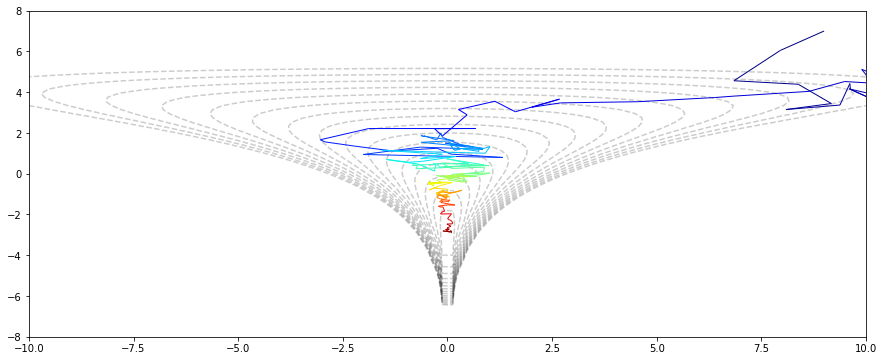

In [8]:
# Create points for contour plot of marginal density
xlim = -10, 10
ylim = -8, 8
levels = np.linspace(-7, -1, 20)
x = np.linspace(*xlim, 80)
y = np.linspace(*ylim, 80)
X, Y = np.meshgrid(x, y)
Z = [[log_pdf.marginal_log_pdf(i, j) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 9])
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Here PINTS' xNES struggles more than CMAES.
We can repeat with more iterations to see what it does next.

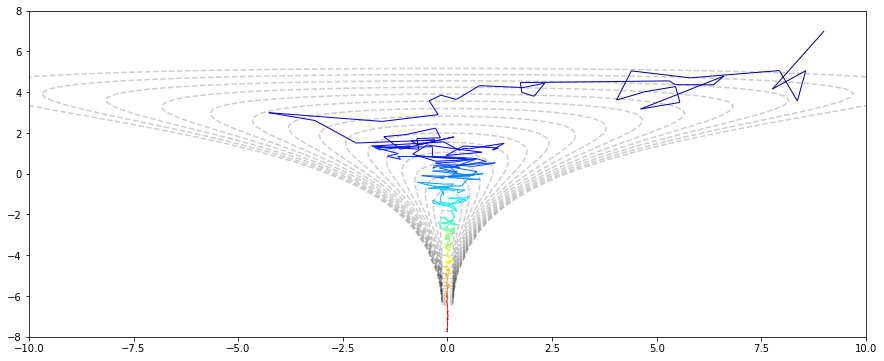

In [9]:
opt = method(x0)
walk = [x0]
for i in range(400):
    opt.tell([-log_pdf(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, colors='k', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 9])
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

So it looks to be OK, just slower.

## Rosenbrock function

A 2d Rosenbrock error is no big deal for xNES:

In [10]:
error = pints.toy.RosenbrockError()
x0 = [-4, -2]

opt = method(x0)
walk = [x0]
for i in range(150):
    opt.tell([error(x) for x in opt.ask()])
    walk.append(opt.x_guessed())
walk = np.array(walk)

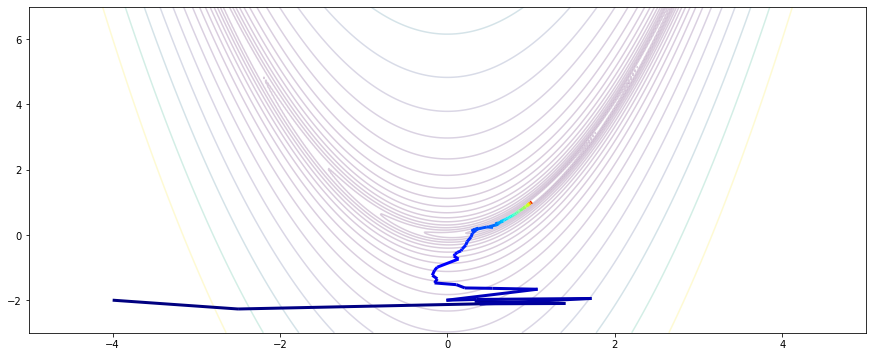

In [11]:
# Create points for contour plot of marginal density
xlim = [-5, 5]
ylim = [-3, 7]
levels = np.geomspace(1, 1e4, 20) - 1
x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

Zoom view:

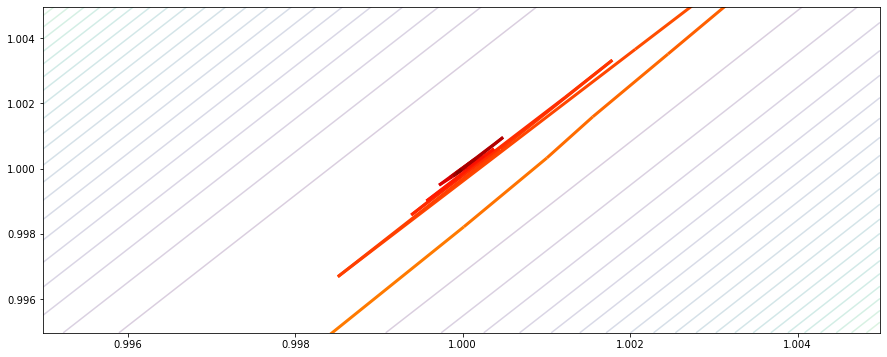

In [12]:
# Create points for contour plot of marginal density
xbest = walk[-1, :]
xlim = [xbest[0] - 0.005, xbest[0] + 0.005]
ylim = [xbest[1] - 0.005, xbest[1] + 0.005]
levels = np.geomspace(1, 1.03, 30) - 1
x = np.linspace(*xlim, 400)
y = np.linspace(*ylim, 400)
X, Y = np.meshgrid(x, y)
Z = [[error([i, j]) for i in x] for j in y]

# Plot contours and optimiser progress
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X, Y, Z, levels=levels, cmap='viridis', alpha=0.2)
technicolor_dreamline(ax, walk[:, 0], walk[:, 1], lw=3)
ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
plt.show()

## Fitzhugh-Nagumo model - fully observable

In [13]:
model = pints.toy.FitzhughNagumoModel()

xtrue = model.suggested_parameters()
times = model.suggested_times()
values = model.simulate(xtrue, times)
r = np.random.default_rng(1)  # Create a seeded generator to get reproducible noise
values += r.normal(0, 0.5, values.shape)
problem = pints.MultiOutputProblem(model, times, values)

error = pints.SumOfSquaresError(problem)
xlim = [1e-3, 2]
ylim = [1e-3, 2]
zlim = [1e-3, 10]
boundaries = np.vstack((xlim, ylim, zlim)).T
boundaries = pints.RectangularBoundaries(boundaries[0], boundaries[1])

In [14]:
# Use a fixed starting point for this one
x0 = xtrue * 1.3

controller = pints.OptimisationController(
    error, x0, boundaries=boundaries, method=method)
controller.set_parallel(parallel)

b = pints.Timer()
xbest, fbest = controller.run()
print(b.format())

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in parallel with 7 worker processes.
Population size: 7
Iter. Eval. Best      Current   Time    
0     4      112.7745  112.7745   0:00.1
1     10     112.7745  256.1269   0:00.1
2     15     112.7745  141.0166   0:00.1
3     21     112.7745  115.7665   0:00.2
20    126    83.84808  83.84808   0:00.6
40    260    83.65472  85.25226   0:01.2
60    400    83.07504  83.08836   0:01.8
80    540    83.07183  83.07183   0:02.4
100   680    83.07135  83.07135   0:03.0
120   820    83.07134  83.07134   0:03.6
140   960    83.07134  83.07134   0:04.3
160   1100   83.07134  83.07134   0:04.9
180   1240   83.07134  83.07134   0:05.6
200   1380   83.07134  83.07134   0:06.2
220   1520   83.07134  83.07134   0:06.8
240   1660   83.07134  83.07134   0:07.3
260   1800   83.07134  83.07134   0:08.0
280   1940   83.07134  83.07134   0:08.6
300   2080   83.07134  83.07134   0:09.2
320   2220   83.07134  83.07134   0:09.

  Found       xbest        Relative error
   8.713e-02   1.000e-01  -12.871% 
   5.733e-01   5.000e-01   14.665% 
   2.929e+00   3.000e+00  -2.359% 



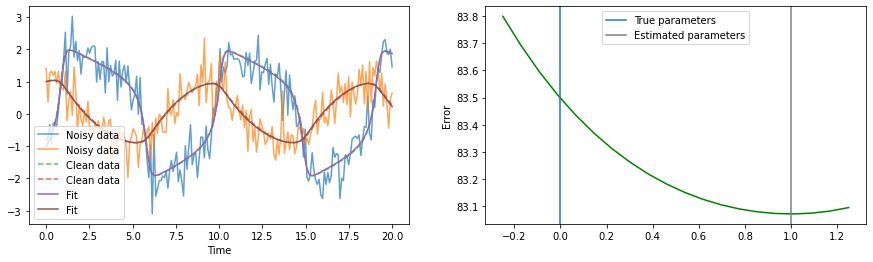

In [15]:
print('  Found       xbest        Relative error' )
for x, y in zip(xbest, xtrue):
    e = (x - y) / y    
    print(f'  {x:> 3.3e}  {y:> 3.3e}  {e:> 3.3%} ')
print()

fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 2, 1)
ax.set_xlabel('Time')
ax.set_label('Value')
ax.plot(times, values, label='Noisy data', alpha=0.7)
ax.plot(times, problem.evaluate(xtrue), '--', label='Clean data', alpha=0.7)
ax.plot(times, problem.evaluate(xbest), label='Fit')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
function_between_points(ax, error, xtrue, xbest)

plt.show()

As with CMAES, we see rapid convergence from the chosen starting point.

# Testing performance

## 2D Parabola

If this doesn't work, something is broken.

In [19]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 50, 20), 20, cp.two_dim_parabola, parallel)
print(t.format())

0.91 seconds


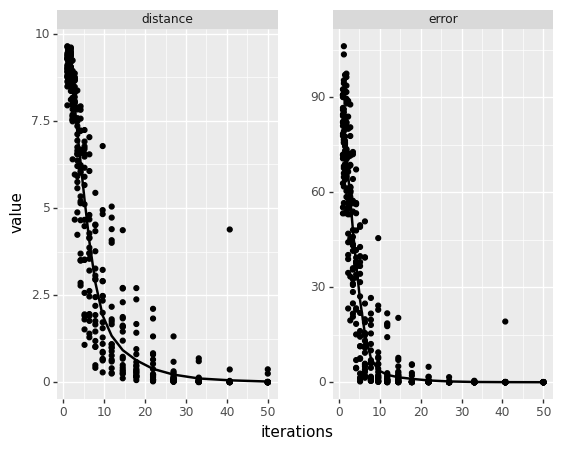

<ggplot: (8746559149341)>

In [20]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.25, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Both lines move in the right direction, and the error quickly goes to zero.
Performance seems to be slightly worse than CMA-ES.

## Rosenbrock function

In [42]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 500, 25), 20, cp.rosenbrock, parallel)
print(t.format())

2.25 seconds


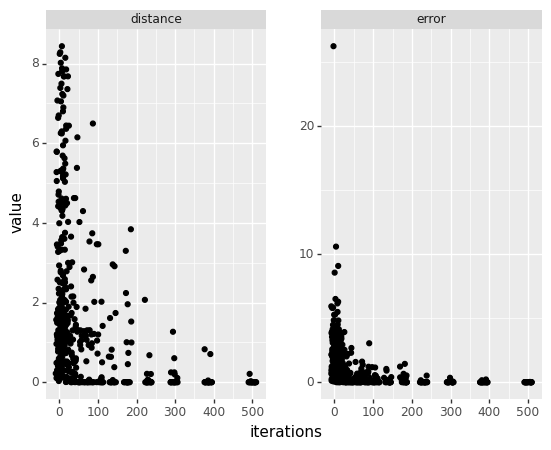

<ggplot: (8746558491857)>

In [48]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=10)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

As before, there's a few more outliers here than with CMA-ES, but performance is good on most runs.

The `geom_smooth` method fails miserably here, so not plotting a line through the points.

## Bounded, untransformed logistic model

In [49]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 300, 30), 10, cp.bounded_untransformed_logistic, parallel)
print(t.format())

1.91 seconds


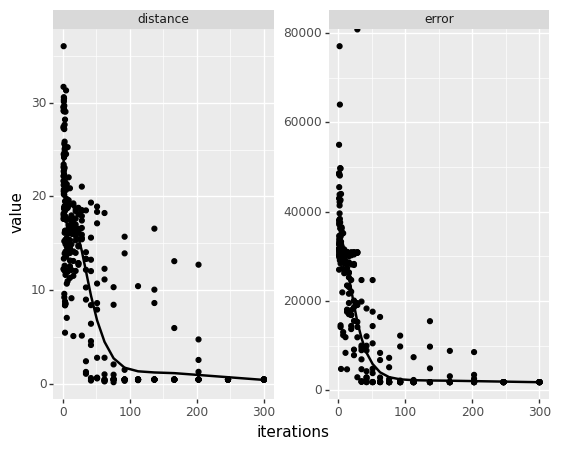

<ggplot: (8746591237169)>

In [50]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

Again some more outliers than CMA-ES, but overal good performance.

## Bounded Fitzhugh-Nagumo

In [57]:
t = pints.Timer()
test = run_replicates(np.geomspace(1, 100, 10), 20, cp.bounded_fitzhugh_nagumo, parallel)
print(t.format())

15.61 seconds


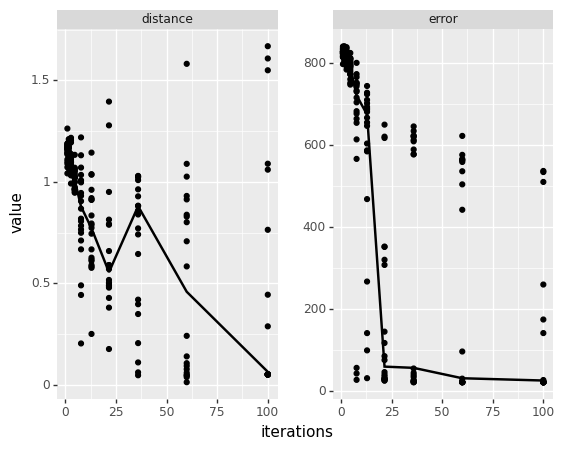

<ggplot: (8746558567905)>

In [58]:
df = pd.melt(test, id_vars=['iterations', 'replicate'])
(ggplot(df, aes(x='iterations', y='value'))
 + geom_jitter(width=0)
 + geom_smooth(span=0.3, se=False)
 + facet_wrap('variable', scales='free')
 + theme(subplots_adjust={'wspace': 0.25})
)

The pattern continues: significantly more outliers than CMA-ES here, but a similar all-or-nothing convergence.